In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

import cv2

from glob import glob
import os
import shutil

from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [137]:
with open('data/markup/104.json') as f:
    text = f.read()
    data = json.loads(text)

# COCO

In [138]:
with open('annotation_coco.json') as f:
    text = f.read()
    temp = json.loads(text)

In [132]:
coco = {}
coco['images'] = []
coco['annotations'] = []
coco['categories'] = []

## add images

In [54]:
ids = []
file_names = []
heights = []
widths = []

i = 0

for file in tqdm(glob('data/images/*')):
    
    image = cv2.imread(file)
    
    ids.append(i)
    i+=1
    
    file_names.append(file.split('/')[-1])
    
    heights.append(image.shape[0])
    widths.append(image.shape[1])
    
for i in range(len(ids)):
    coco['images'].append({'id': ids[i], 'file_name': file_names[i],
                           'height': heights[i], 'width': widths[i]})

100%|█████████████████████████████████████████| 200/200 [00:43<00:00,  4.64it/s]


## add annotations

In [115]:
i = 0

for coco_image in coco['images']:
    
    file_name = coco_image['file_name']
    
    with open('data/markup/'+file_name.split('.')[0]+'.json') as f:
        markups = json.loads(f.read())

    for markup in markups:
        
        annot_temp = {}
    
        annot_temp['image_id'] = coco_image['id']
        annot_temp['id'] = i
        i += 1
        annot_temp['category_id'] = 1
        
        annot_temp['bbox'] = markup['bbox'][:4]
        
        annot_temp['area'] = markup['bbox'][2] * markup['bbox'][3]
        annot_temp['segmentation'] = markup['segmentation_poly']
        annot_temp['iscrowd'] = 0
        
        coco['annotations'].append(annot_temp)

In [120]:
coco['annotations'][0].keys()

dict_keys(['image_id', 'id', 'category_id', 'bbox', 'area', 'segmentation', 'iscrowd'])

## add categories

In [124]:
temp['categories']

[{'id': 0, 'name': 'balloon'}]

In [126]:
coco['categories'] = [{'id': 1, 'name': 'walrus'}]

## save

In [131]:
with open('morzh_coco/annotation_coco.json', 'w') as f:
    json.dump(coco, f)

## all in func

In [251]:
train_filenames, val_filenames = train_test_split(glob('data/images/*'), test_size=0.1, random_state=17)

In [252]:
def made_coco_data(filenames, path_to_save):
    
    coco = {}
    coco['images'] = []
    coco['annotations'] = []
    coco['categories'] = []
    
    
    ids = []
    file_names = []
    heights = []
    widths = []
    
    i = 0
    
    for file in tqdm(filenames):
        
        image = cv2.imread(file)
        shutil.copy(file, path_to_save)
        
        ids.append(i)
        i+=1
        
        file_names.append(file.split('/')[-1])
        
        heights.append(image.shape[0])
        widths.append(image.shape[1])
        
    for i in range(len(ids)):
        coco['images'].append({'id': ids[i], 'file_name': file_names[i],
                               'height': heights[i], 'width': widths[i]})
        

    i = 0
    
    for coco_image in tqdm(coco['images']):
        
        file_name = coco_image['file_name']
        
        with open('data/markup/'+file_name.split('.')[0]+'.json') as f:
            markups = json.loads(f.read())
    
        for markup in markups:
            
            annot_temp = {}
        
            annot_temp['image_id'] = coco_image['id']
            annot_temp['id'] = i
            i += 1
            annot_temp['category_id'] = 1
            
            annot_temp['bbox'] = markup['bbox'][:4]
            
            annot_temp['area'] = markup['bbox'][2] * markup['bbox'][3]
            annot_temp['segmentation'] = markup['segmentation_poly']
            annot_temp['iscrowd'] = 0
            
            
            for j, val in enumerate(annot_temp['segmentation'][0]):
                if j%2 == 0 and val > coco_image['width']:
                    annot_temp['segmentation'][0][j] = coco_image['width']
                    # print('replace segm width')
                elif j%2 != 0 and val > coco_image['height']:
                    annot_temp['segmentation'][0][j] = coco_image['height']
                    # print('replace segm height')
                    
                if val < 0:
                    annot_temp['segmentation'][0][j] = 0
                    # print('replace segm 0')
            
            if len(annot_temp['segmentation'][0]) > 4:
                coco['annotations'].append(annot_temp)
            
    coco['categories'] = [{'id': 1, 'name': 'walrus'}]
    
    with open(path_to_save+'annotation_coco.json', 'w') as f:
        json.dump(coco, f)

In [253]:
made_coco_data(train_filenames, 'morzh_coco/train/')

100%|████████████████████████████████████████| 180/180 [00:01<00:00, 115.26it/s]


In [254]:
made_coco_data(val_filenames, 'morzh_coco/val/')

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 189.95it/s]


In [3]:
with open('morzh_coco/train/annotation_coco.json') as f:
    temp = json.loads(f.read())

'88.jpg'

In [17]:
with open('data/markup/DJI_0006 (2).json') as f:
    markups = json.loads(f.read())
len(markups)

299

In [10]:
max_len = 0

for file_name in glob('data/images/*'):
        
    file_name = file_name.split('/')[-1]
        
    with open('data/markup/'+file_name.split('.')[0]+'.json') as f:
        markups = json.loads(f.read())
       
    if len(markups) > max_len:
        max_len = len(markups)
        print(file_name, len(markups))

88.jpg 312
DJI_0052.jpg 828
DJI_0079.jpg 923
DJI_0078.jpg 932
DJI_0076.jpg 948


In [263]:
for i in range(len(temp['annotations'])):
    
    image_id = temp['annotations'][i]['image_id']
    
    file_name = temp['images'][image_id]['file_name']
    height = temp['images'][image_id]['height']
    width = temp['images'][image_id]['width']
    
    bbox = temp['annotations'][i]['bbox']
    segmentation = temp['annotations'][i]['segmentation']
    
    if len(segmentation[0]) < 6:
        print(segmentation[0])
    
#     max_width = 0
#     max_height = 0
#     for j, val in enumerate(segmentation[0]):
#         if j%2 == 0 and val > max_width:
#             max_width = val
#         elif j%2 != 0 and val > max_height:
#             max_height = val
            
#         if val < 0:
#             print(val)
    
#     # if len(segmentation[0]) < 4 or len(segmentation[0])%2 != 0:
#         # print(segmentation)
        
#     if max_width > width or max_height > height:
#         print(width, height)
#         print(segmentation)

In [203]:
segmentation[0]

[2467.0,
 681.75,
 2477.0,
 663.0,
 2493.0,
 637.0,
 2476.75,
 623.0,
 2441.0,
 619.25,
 2414.25,
 634.0,
 2380.25,
 646.5,
 2365.25,
 666.5,
 2364.75,
 688.25,
 2367.5,
 702.0,
 2378.25,
 702.75,
 2389.75,
 697.75,
 2433.25,
 691.25,
 2446.0,
 684.75]

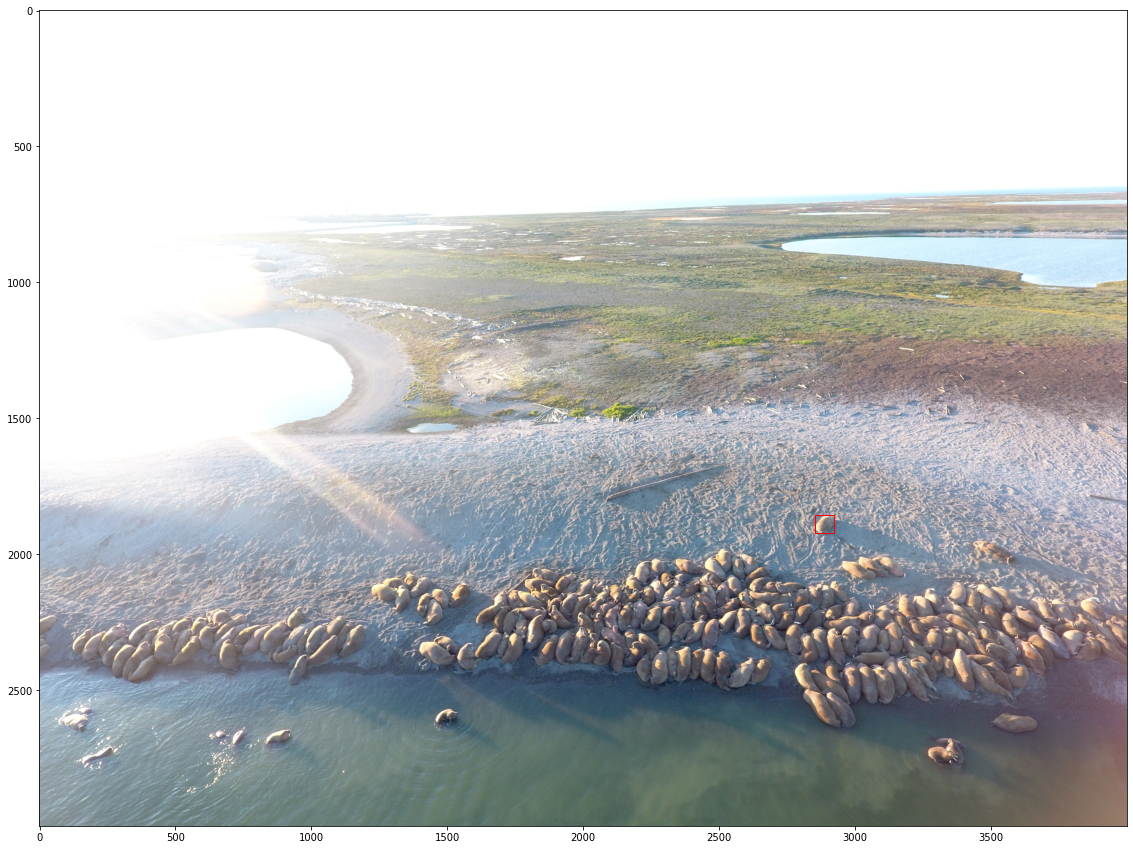

In [174]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(20, 15))

# Display the image
ax.imshow(cv2.cvtColor(cv2.imread('morzh_coco/train/'+file_name), cv2.COLOR_BGR2RGB))

# Create a Rectangle patch
rect = patches.Rectangle((2852.5, 1857.5), 71, 65, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [224]:
with open('morzh_coco/train/annotation_coco.json') as f:
    temp = json.loads(f.read())

In [227]:
minh = 5000
minw = 5000

for t in temp['images']:
    if t['height'] < minh:
        minh = t['height']
    if t['width'] < minw:
        minw = t['width']

In [228]:
minh

1080

In [229]:
minw

1632

# разрезание картинок

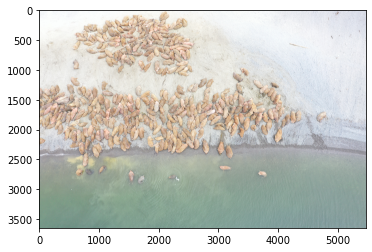

In [19]:
plt.imshow(cv2.cvtColor(cv2.imread('morzh_coco/val/DJI_0086.jpg').copy(), cv2.COLOR_BGR2RGB))

In [23]:
image = cv2.imread('morzh_coco/val/DJI_0086.jpg').copy()

In [27]:
xsplit = image.shape[1] // 3

image1 = image[:, :xsplit, :].copy()
image2 = image[:, xsplit:2*xsplit, :].copy()
image3 = image[:, 2*xsplit:, :].copy()

In [37]:
glob('morzh_coco/val/*.jpg')[0].split('/')[-1].split('.')[0]

'88'

In [60]:
xsplit_values = []
files = []

for file in glob('morzh_coco/val/*.jpg'):
    
    image = cv2.imread(file).copy()
    
    if image.shape[1] > 4000:
        xsplit = image.shape[1] // 3
        xsplit_values.append(xsplit)
        image1 = image[:, :xsplit, :].copy()
        image2 = image[:, xsplit:2*xsplit, :].copy()
        image3 = image[:, 2*xsplit:, :].copy()
        
        filedir = file.split('/')[-1].split('.')[0]
        os.mkdir(f'split_images/{filedir}')
        cv2.imwrite(f'split_images/{filedir}/1.jpg', image1)
        cv2.imwrite(f'split_images/{filedir}/2.jpg', image2)
        cv2.imwrite(f'split_images/{filedir}/3.jpg', image3)
        
    
    elif image.shape[1] > 3000:
        xsplit = image.shape[1] // 2
        xsplit_values.append(xsplit)
        image1 = image[:, :xsplit, :].copy()
        image2 = image[:, xsplit:, :].copy()
        
        filedir = file.split('/')[-1].split('.')[0]
        os.mkdir(f'split_images/{filedir}')
        cv2.imwrite(f'split_images/{filedir}/1.jpg', image1)
        cv2.imwrite(f'split_images/{filedir}/2.jpg', image2)
        
    else:
        xsplit_values.append(0)
        filedir = file.split('/')[-1].split('.')[0]
        os.mkdir(f'split_images/{filedir}')
        cv2.imwrite(f'split_images/{filedir}/1.jpg', image)
        
    files.append(file)

In [61]:
xsplit_df = pd.DataFrame()
xsplit_df['xsplit'] = xsplit_values
xsplit_df['file'] = files
xsplit_df['file'] = xsplit_df['file'].apply(lambda x: x.split('/')[-1].split('.')[0])
xsplit_df.to_csv('xsplit_values.csv', index=False)

In [63]:
xsplit_df

,xsplit,file
0,1920,88
1,1824,DJI_0086
2,2000,DJI_0006 (2)
3,2000,DJI_0023
4,2000,DJI_0022
5,0,13
6,0,104
7,2000,DJI_0020
8,1824,DJI_0020 (3)
9,2000,DJI_0039


In [67]:
for filedir in glob('split_images/*'):
    
    file_csv = filedir.split('/')[-1]
    
    for file in glob(filedir+'/*'):
        
        res_df = get_res_df(file)
        
        xsplit_value = float(file.split('/')[-1].split('.')[0])
        xsplit = xsplit_df[xsplit_df.file == file_csv].xsplit.iloc[0]
        
        res_df['x'] += xsplit_value*xsplit
        
        res_df.to_csv(f'results/{file_csv}.csv', index=False)

In [71]:
glob(filedir+'/*')[0].split('/')[-1].split('.')[0]

'1'

In [47]:
file_csv

'92'

In [86]:
import glob
from PIL import Image

# filepaths
# fp_in = "/gif/*.png"
files = [f'./gif/{i}.png' for i in range(1, 252)]
fp_out = "./morzh.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
imgs = (Image.open(f).resize((720, 405)) for f in files)
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

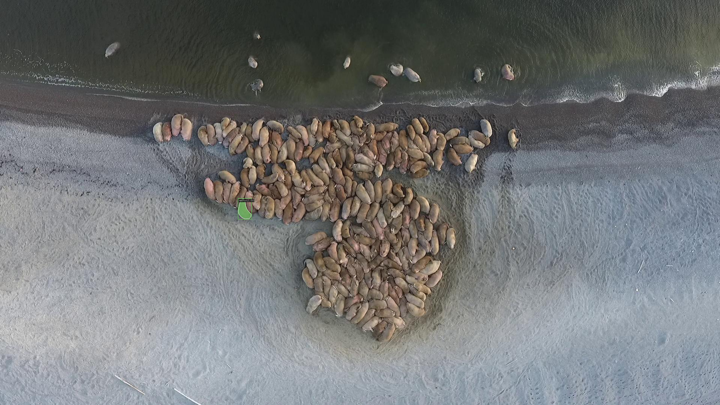

In [87]:
img

In [85]:
720 * 1080/1920

405.0